In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
FOLD=2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from efficientnet_pytorch import EfficientNet
from fastaudio.augment.spectrogram import CropTime

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything(1234)

In [6]:
path = Path("/home/kkalyan/agri-split/data")

In [7]:
(path/"audio_files").ls()

(#2126) [Path('/home/kkalyan/agri-split/data/audio_files/BK8UDCM.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3B5A2P3.wav'),Path('/home/kkalyan/agri-split/data/audio_files/7QXN2WO.wav'),Path('/home/kkalyan/agri-split/data/audio_files/E04FSN7.wav'),Path('/home/kkalyan/agri-split/data/audio_files/O0L4PC1.wav'),Path('/home/kkalyan/agri-split/data/audio_files/0TYHMIF.wav'),Path('/home/kkalyan/agri-split/data/audio_files/48PTKS5.wav'),Path('/home/kkalyan/agri-split/data/audio_files/J28NE2C.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3J8WKXR.wav'),Path('/home/kkalyan/agri-split/data/audio_files/67FIJLB.wav')...]

In [8]:
df = pd.read_csv(path/"Train_v.csv")
df.head()

,fn,label,fold
0,audio_files/IV38R7F.wav,akawuka,1
1,audio_files/KM4SKWT.wav,banana,1
2,audio_files/F5POSU9.wav,obulwadde,3
3,audio_files/MMVDXG2.wav,nnyaanya,1
4,audio_files/9TVM96F.wav,pampu,1


In [9]:
ct = CropTime(duration=1000)
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [10]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [11]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock), 
                 get_x=ColReader("fn", pref=path), 
                 batch_tfms = [a2s],
                 splitter=CrossValidationSplitter(fold=FOLD),
                 item_tfms=[ResizeSignal(3000), SignalShifter(), AddNoise(), ChangeVolume(), SignalLoss()],
                 get_y=ColReader("label"))

In [12]:
dbunch = auds.dataloaders(df, bs=128)

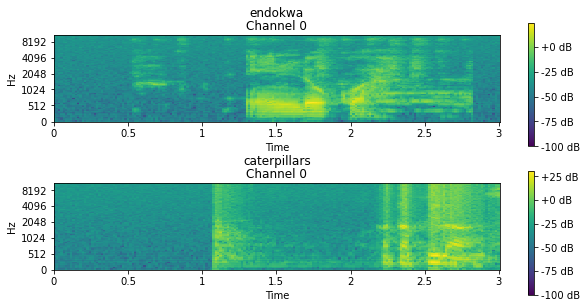

In [13]:
dbunch.show_batch(figsize=(10, 5))

In [14]:
learn = cnn_learner(dbunch, 
            xresnet18, 
            config=cnn_config(n_in=1),
            loss_fn=LabelSmoothingCrossEntropy,
            metrics=[accuracy]).to_fp16()

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /home/kkalyan/.cache/torch/hub/checkpoints/xrn50_940.pth


In [15]:
x,y = next(iter(learn.dls.train))

In [16]:
x.shape

torch.Size([128, 1, 128, 188])

In [17]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,7.064826,14.414640,0.005405,00:03


epoch,train_loss,valid_loss,accuracy,time
0,7.071119,8.447865,0.002703,00:04
1,7.107666,6.397918,0.005405,00:04
2,6.884718,5.675314,0.008108,00:04
3,6.640298,5.459550,0.018919,00:04
4,6.456626,5.291949,0.016216,00:05
5,6.294641,5.230209,0.010811,00:05
6,6.119577,5.170141,0.032432,00:05
7,5.974416,5.161952,0.024324,00:06
8,5.858616,5.160916,0.029730,00:05
9,5.753297,5.197126,0.018919,00:05


In [18]:
learn.fit_one_cycle(150, 1e-3, cbs=[EarlyStoppingCallback(patience=20), SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,5.101254,5.177653,0.027027,00:05
1,5.135495,5.134872,0.016216,00:06
2,5.174657,5.156883,0.027027,00:04
3,5.204301,5.110832,0.027027,00:04
4,5.168658,5.131274,0.032432,00:05
5,5.145767,5.093293,0.035135,00:05
6,5.127808,5.060145,0.035135,00:05
7,5.134300,5.098226,0.027027,00:05
8,5.107865,5.068262,0.040541,00:05
9,5.077801,5.141996,0.029730,00:05


Better model found at epoch 0 with valid_loss value: 5.1776533126831055.
Better model found at epoch 1 with valid_loss value: 5.134871959686279.
Better model found at epoch 3 with valid_loss value: 5.1108317375183105.
Better model found at epoch 5 with valid_loss value: 5.093292713165283.
Better model found at epoch 6 with valid_loss value: 5.060144901275635.
Better model found at epoch 11 with valid_loss value: 5.035663604736328.
Better model found at epoch 14 with valid_loss value: 5.016713619232178.
Better model found at epoch 16 with valid_loss value: 5.003069877624512.
Better model found at epoch 18 with valid_loss value: 5.000213623046875.
Better model found at epoch 21 with valid_loss value: 4.936203479766846.
Better model found at epoch 23 with valid_loss value: 4.925300121307373.
Better model found at epoch 28 with valid_loss value: 4.814281463623047.
Better model found at epoch 29 with valid_loss value: 4.778492450714111.
Better model found at epoch 30 with valid_loss value: 

In [19]:
learn.load('save-nb-{}'.format(FOLD))

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=8.31763736641733e-06)

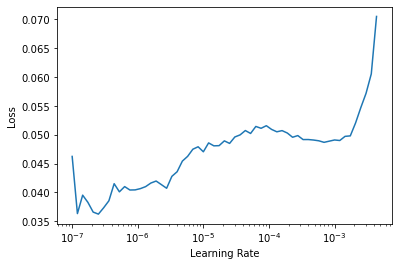

In [20]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [21]:
learn.fit_one_cycle(150, slice(1e-5, 1e-3), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.052714,3.431454,0.343243,00:05
1,0.052799,3.449270,0.351351,00:06
2,0.046695,3.366051,0.362162,00:04
3,0.047956,3.480635,0.340541,00:04
4,0.048526,3.415902,0.332432,00:05
5,0.049109,3.448011,0.359459,00:04
6,0.047659,3.381330,0.354054,00:04
7,0.046311,3.429772,0.356757,00:05
8,0.048660,3.462957,0.356757,00:04
9,0.048826,3.435856,0.343243,00:04


Better model found at epoch 0 with valid_loss value: 3.4314539432525635.
Better model found at epoch 2 with valid_loss value: 3.366051197052002.
No improvement since epoch 2: early stopping


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

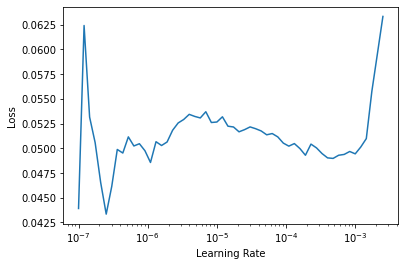

In [22]:
learn.lr_find(suggestions=True)

In [23]:
learn.load('save-nb-{}'.format(FOLD))

In [24]:
learn.fit_one_cycle(150, slice(4e-7, 1e-5), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.042084,3.414582,0.367568,00:04
1,0.047526,3.453843,0.351351,00:04
2,0.047104,3.389708,0.362162,00:04
3,0.047092,3.468379,0.345946,00:04
4,0.046169,3.443555,0.362162,00:06
5,0.046116,3.473772,0.340541,00:05
6,0.046223,3.490025,0.348649,00:05
7,0.047642,3.481070,0.354054,00:05
8,0.046886,3.438935,0.351351,00:06
9,0.046083,3.450517,0.345946,00:04


Better model found at epoch 0 with valid_loss value: 3.4145824909210205.
Better model found at epoch 2 with valid_loss value: 3.3897078037261963.
No improvement since epoch 2: early stopping


SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=2.75422871709452e-06)

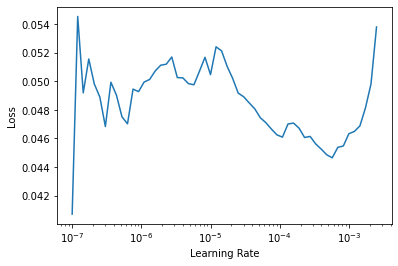

In [25]:
learn.lr_find(suggestions=True)

In [26]:
learn.load('save-nb-{}'.format(FOLD))

In [27]:
learn.fit_one_cycle(150, slice(1e-8, 1e-6), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.052488,3.456169,0.362162,00:05
1,0.047018,3.496238,0.332432,00:04
2,0.046467,3.440490,0.354054,00:04
3,0.047312,3.441760,0.354054,00:04
4,0.048939,3.428769,0.337838,00:05
5,0.049836,3.401385,0.367568,00:03
6,0.047302,3.473057,0.354054,00:03
7,0.046808,3.462617,0.348649,00:05
8,0.047887,3.423252,0.332432,00:04
9,0.047467,3.428300,0.370270,00:03


Better model found at epoch 0 with valid_loss value: 3.4561688899993896.
Better model found at epoch 2 with valid_loss value: 3.4404897689819336.
Better model found at epoch 4 with valid_loss value: 3.428769111633301.
Better model found at epoch 5 with valid_loss value: 3.4013853073120117.
Better model found at epoch 21 with valid_loss value: 3.390286922454834.
No improvement since epoch 21: early stopping


In [28]:
learn.load('save-nb-{}'.format(FOLD))

In [29]:
preds, y = learn.get_preds(dl=dbunch.valid)
acc = accuracy(preds, y); acc

tensor(0.3405)

In [30]:
ss = pd.read_csv(path/'SampleSubmission.csv')
ss['fn'] = ss.fn.apply(lambda x: str(path)+"/"+x)

In [31]:
tdl = learn.dls.test_dl(ss['fn'].values, order=True)
test_preds, test_labels = learn.get_preds(dl=tdl)

In [32]:
for i, label in enumerate(dbunch.vocab):
    ss[label] = [np.round(t[i].numpy(), 4) for t in test_preds]
ss.head()
ss.to_csv('/home/kkalyan/agri-split/submissions/'+'cv_submit-xresnet18-{}.csv'.format(FOLD), index=False)